<a href="https://colab.research.google.com/github/nclarknz/DarkNet-Obj-Training/blob/main/YOLOv4_tiny_Darknet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction


In this notebook, we implement the tiny version of [YOLOv4](https://arxiv.org/pdf/2004.10934.pdf) for training on your own dataset, [YOLOv4 tiny](https://github.com/AlexeyAB/darknet/issues/6067).

We also recommend reading our blog post on [Training YOLOv4 on custom data](https://blog.roboflow.ai/training-yolov4-on-a-custom-dataset/) side by side.

We will take the following steps to implement YOLOv4 on our custom data:
* Configure our GPU environment on Google Colab
* Install the Darknet YOLOv4 training environment
* Download our custom dataset for YOLOv4 and set up directories
* Configure a custom YOLOv4 training config file for Darknet
* Train our custom YOLOv4 object detector
* Reload YOLOv4 trained weights and make inference on test images

When you are done you will have a custom detector that you can use. It will make inference like this:


# Configuring cuDNN on Colab for YOLOv4



In [3]:
# Setup the Google Drive and stuff
from google.colab import drive
drive.mount('/content/gdrive')

%cd /content/gdrive/My Drive/KiwiBoxSet
%cd /content
!ln -s  '/content/gdrive/My Drive/KiwiBoxSet' kiwiboxset

Mounted at /content/gdrive
/content/gdrive/My Drive/KiwiBoxSet
/content


In [2]:
# CUDA: Let's check that Nvidia CUDA drivers are already pre-installed and which version is it.
!/usr/local/cuda/bin/nvcc --version
# We need to install the correct cuDNN according to this output

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243


In [3]:
#take a look at the kind of GPU we have
!nvidia-smi

Thu Oct  1 20:17:34 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Installing Darknet for YOLOv4 on Colab




In [4]:
%cd /content/kiwiboxset
#%rm -rf darknet

/content/gdrive/My Drive/KiwiBoxSet


In [5]:
#we clone the fork of darknet maintained by roboflow
#small changes have been made to configure darknet for training
!git clone https://github.com/roboflow-ai/darknet.git

Cloning into 'darknet'...
remote: Enumerating objects: 13289, done.
remote: Total 13289 (delta 0), reused 0 (delta 0), pack-reused 13289
Receiving objects: 100% (13289/13289), 12.13 MiB | 7.59 MiB/s, done.
Resolving deltas: 100% (9109/9109), done.
Checking out files: 100% (2002/2002), done.


**IMPORTANT! If you're not using a Tesla P100 GPU, then uncomment the sed command and replace the arch and code with that matching your GPU. A list can be found [here](http://arnon.dk/matching-sm-architectures-arch-and-gencode-for-various-nvidia-cards/).**

In [6]:
#install environment from the Makefile
%cd /content/kiwiboxset/darknet/
# compute_30, sm_30 for Tesla K80
# compute_75, sm_75 for Tesla T4
!sed -i 's/ARCH= -gencode arch=compute_60,code=sm_60/ARCH= -gencode arch=compute_75,code=sm_75/g' Makefile
#!sed -i 's/ARCH= -gencode arch=compute_75,code=sm_75/ARCH= -gencode arch=compute_30,code=sm_30/g' Makefile
#install environment from the Makefile
#note if you are on Colab Pro this works on a P100 GPU
#if you are on Colab free, you may need to change the Makefile for the K80 GPU
#this goes for any GPU, you need to change the Makefile to inform darknet which GPU you are running on.
!make clean
!make

/content/gdrive/My Drive/KiwiBoxSet/darknet
rm -rf ./obj/image_opencv.o ./obj/http_stream.o ./obj/gemm.o ./obj/utils.o ./obj/dark_cuda.o ./obj/convolutional_layer.o ./obj/list.o ./obj/image.o ./obj/activations.o ./obj/im2col.o ./obj/col2im.o ./obj/blas.o ./obj/crop_layer.o ./obj/dropout_layer.o ./obj/maxpool_layer.o ./obj/softmax_layer.o ./obj/data.o ./obj/matrix.o ./obj/network.o ./obj/connected_layer.o ./obj/cost_layer.o ./obj/parser.o ./obj/option_list.o ./obj/darknet.o ./obj/detection_layer.o ./obj/captcha.o ./obj/route_layer.o ./obj/writing.o ./obj/box.o ./obj/nightmare.o ./obj/normalization_layer.o ./obj/avgpool_layer.o ./obj/coco.o ./obj/dice.o ./obj/yolo.o ./obj/detector.o ./obj/layer.o ./obj/compare.o ./obj/classifier.o ./obj/local_layer.o ./obj/swag.o ./obj/shortcut_layer.o ./obj/activation_layer.o ./obj/rnn_layer.o ./obj/gru_layer.o ./obj/rnn.o ./obj/rnn_vid.o ./obj/crnn_layer.o ./obj/demo.o ./obj/tag.o ./obj/cifar.o ./obj/go.o ./obj/batchnorm_layer.o ./obj/art.o ./obj/regio

In [ ]:
%cd /content/kiwiboxset/darknet/data/obj.zip\ \(Unzipped\ Files\)/obj
#%mv * /content/kiwiboxset/darknet/data/obj/
%ls -l /content/kiwiboxset/darknet/data/obj | wc -l
%ls -l /content/kiwiboxset/darknet/data/obj.zip\ \(Unzipped\ Files\)/obj | wc -l


/content/gdrive/My Drive/KiwiBoxSet/darknet/data/obj.zip (Unzipped Files)/obj
7147
1


In [ ]:
#download the newly released yolov4-tiny weights
%cd /content/kiwiboxset/darknet
!wget https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v4_pre/yolov4-tiny.weights
!wget https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v4_pre/yolov4-tiny.conv.29
#!wget https://raw.githubusercontent.com/AlexeyAB/darknet/master/cfg/yolov4-tiny.cfg

# Set up Custom Dataset for YOLOv4

We'll use Roboflow to convert our dataset from any format to the YOLO Darknet format. 

1. To do so, create a free [Roboflow account](https://app.roboflow.ai).
2. Upload your images and their annotations (in any format: VOC XML, COCO JSON, TensorFlow CSV, etc).
3. Apply preprocessing and augmentation steps you may like. We recommend at least `auto-orient` and a `resize` to 416x416. Generate your dataset.
4. Export your dataset in the **YOLO Darknet format**.
5. Copy your download link, and paste it below.

See our [blog post](https://blog.roboflow.ai/training-yolov4-on-a-custom-dataset/) for greater detail.

In this example, I used the open source [BCCD Dataset](https://public.roboflow.ai/object-detection/bccd). (You can `fork` it to your Roboflow account to follow along.)

In [ ]:
#if you already have YOLO darknet format, you can skip this step
#otherwise we recommend formatting in Roboflow
#%cd /content/darknet
#!curl -L "[YOUR LINK HERE]" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

In [13]:
#Set up training file directories for custom dataset
%cd /content/kiwiboxset/darknet/data/obj/12.zip\ \(Unzipped\ Files\)/
#%cp train/_darknet.labels data/obj.names
#%mkdir data/obj
#copy image and labels
#%cp train/*.jpg data/obj/
#%cp valid/*.jpg data/obj/
%mv * /content/kiwiboxset/darknet/data/obj
#%cp train/*.txt data/obj/
#%cp valid/*.txt data/obj/

#with open('data/obj.data', 'w') as out:
#  out.write('classes = 26\n')
#  out.write('train = data/train.txt\n')
#  out.write('valid = data/valid.txt\n')
#  out.write('names = data/obj.names\n')
#  out.write('backup = backup/')

#write train file (just the image list)
import os

#with open('data/train.txt', 'w') as out:
#  for img in [f for f in os.listdir('train') if f.endswith('jpg')]:
#    out.write('data/obj/' + img + '\n')

#write the valid file (just the image list)
#import os

#with open('data/valid.txt', 'w') as out:
#  for img in [f for f in os.listdir('valid') if f.endswith('jpg')]:
#    out.write('data/obj/' + img + '\n')

/content/gdrive/My Drive/KiwiBoxSet/darknet/data/obj/12.zip (Unzipped Files)


# Write Custom Training Config for YOLOv4

In [8]:
#we build config dynamically based on number of classes
#we build iteratively from base config files. This is the same file shape as cfg/yolo-obj.cfg
def file_len(fname):
  with open(fname) as f:
    for i, l in enumerate(f):
      pass
  return i + 1

num_classes = file_len('data/obj.names')
max_batches = num_classes*5000
steps1 = .8 * max_batches
steps2 = .9 * max_batches
steps_str = str(steps1)+','+str(steps2)
num_filters = (num_classes + 5) * 3


print("writing config for a custom YOLOv4 detector detecting number of classes: " + str(num_classes))

#Instructions from the darknet repo
#change line max_batches to (classes*2000 but not less than number of training images, and not less than 6000), f.e. max_batches=6000 if you train for 3 classes
#change line steps to 80% and 90% of max_batches, f.e. steps=4800,5400
if os.path.exists('./cfg/custom-yolov4-tiny-detector.cfg'): os.remove('./cfg/custom-yolov4-tiny-detector.cfg')


#customize iPython writefile so we can write variables
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

  



writing config for a custom YOLOv4 detector detecting number of classes: 26


In [9]:
%%writetemplate ./cfg/custom-yolov4-tiny-detector.cfg
[net]
# Testing
#batch=1
#subdivisions=1
# Training
batch=64
subdivisions=24
width=416
height=416
channels=3
momentum=0.9
decay=0.0005
angle=0
saturation = 1.5
exposure = 1.5
hue=.1

learning_rate=0.00261
burn_in=1000
max_batches = {max_batches}
policy=steps
steps={steps_str}
scales=.1,.1

[convolutional]
batch_normalize=1
filters=32
size=3
stride=2
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=64
size=3
stride=2
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=64
size=3
stride=1
pad=1
activation=leaky

[route]
layers=-1
groups=2
group_id=1

[convolutional]
batch_normalize=1
filters=32
size=3
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=32
size=3
stride=1
pad=1
activation=leaky

[route]
layers = -1,-2

[convolutional]
batch_normalize=1
filters=64
size=1
stride=1
pad=1
activation=leaky

[route]
layers = -6,-1

[maxpool]
size=2
stride=2

[convolutional]
batch_normalize=1
filters=128
size=3
stride=1
pad=1
activation=leaky

[route]
layers=-1
groups=2
group_id=1

[convolutional]
batch_normalize=1
filters=64
size=3
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=64
size=3
stride=1
pad=1
activation=leaky

[route]
layers = -1,-2

[convolutional]
batch_normalize=1
filters=128
size=1
stride=1
pad=1
activation=leaky

[route]
layers = -6,-1

[maxpool]
size=2
stride=2

[convolutional]
batch_normalize=1
filters=256
size=3
stride=1
pad=1
activation=leaky

[route]
layers=-1
groups=2
group_id=1

[convolutional]
batch_normalize=1
filters=128
size=3
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=128
size=3
stride=1
pad=1
activation=leaky

[route]
layers = -1,-2

[convolutional]
batch_normalize=1
filters=256
size=1
stride=1
pad=1
activation=leaky

[route]
layers = -6,-1

[maxpool]
size=2
stride=2

[convolutional]
batch_normalize=1
filters=512
size=3
stride=1
pad=1
activation=leaky

##################################

[convolutional]
batch_normalize=1
filters=256
size=1
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=512
size=3
stride=1
pad=1
activation=leaky

[convolutional]
size=1
stride=1
pad=1
filters={num_filters}
activation=linear



[yolo]
mask = 3,4,5
anchors = 10,14,  23,27,  37,58,  81,82,  135,169,  344,319
classes={num_classes}
num=6
jitter=.3
scale_x_y = 1.05
cls_normalizer=1.0
iou_normalizer=0.07
iou_loss=ciou
ignore_thresh = .7
truth_thresh = 1
random=0
nms_kind=greedynms
beta_nms=0.6

[route]
layers = -4

[convolutional]
batch_normalize=1
filters=128
size=1
stride=1
pad=1
activation=leaky

[upsample]
stride=2

[route]
layers = -1, 23

[convolutional]
batch_normalize=1
filters=256
size=3
stride=1
pad=1
activation=leaky

[convolutional]
size=1
stride=1
pad=1
filters={num_filters}
activation=linear

[yolo]
mask = 1,2,3
anchors = 10,14,  23,27,  37,58,  81,82,  135,169,  344,319
classes={num_classes}
num=6
jitter=.3
scale_x_y = 1.05
cls_normalizer=1.0
iou_normalizer=0.07
iou_loss=ciou
ignore_thresh = .7
truth_thresh = 1
random=0
nms_kind=greedynms
beta_nms=0.6
max=200

In [10]:
#here is the file that was just written. 
#you may consider adjusting certain things

#like the number of subdivisions 64 runs faster but Colab GPU may not be big enough
#if Colab GPU memory is too small, you will need to adjust subdivisions to 16
%cat cfg/custom-yolov4-tiny-detector.cfg

[net]
# Testing
#batch=1
#subdivisions=1
# Training
batch=64
subdivisions=24
width=416
height=416
channels=3
momentum=0.9
decay=0.0005
angle=0
saturation = 1.5
exposure = 1.5
hue=.1

learning_rate=0.00261
burn_in=1000
max_batches = 130000
policy=steps
steps=104000.0,117000.0
scales=.1,.1

[convolutional]
batch_normalize=1
filters=32
size=3
stride=2
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=64
size=3
stride=2
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=64
size=3
stride=1
pad=1
activation=leaky

[route]
layers=-1
groups=2
group_id=1

[convolutional]
batch_normalize=1
filters=32
size=3
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=32
size=3
stride=1
pad=1
activation=leaky

[route]
layers = -1,-2

[convolutional]
batch_normalize=1
filters=64
size=1
stride=1
pad=1
activation=leaky

[route]
layers = -6,-1

[maxpool]
size=2
stride=2

[convolutional]
batch_normalize=1
filters=128
size=3
stride=1
pad=1
activation=leaky



# Train Custom YOLOv4 Detector

In [ ]:
%cd /content/kiwiboxset/darknet/
!./darknet detector train data/obj.data cfg/custom-yolov4-tiny-detector.cfg yolov4-tiny.conv.29 -dont_show -map
#!./darknet detector train data/obj.data cfg/custom-yolov4-tiny-detector.cfg backup/custom-yolov4-tiny-detector_last.weights -dont_show -map
#If you get CUDA out of memory adjust subdivisions above!
#adjust max batches down for shorter training above

# Infer Custom Objects with Saved YOLOv4 Weights

In [ ]:
%cd /content/kiwiboxset/darknet/

/content/gdrive/My Drive/KiwiBoxSet/darknet


In [ ]:
import os
#define utility function
def imShow(path):
  import cv2
  import matplotlib.pyplot as plt
  %matplotlib inline

  image = cv2.imread(path)
  height, width = image.shape[:2]
  resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)

  fig = plt.gcf()
  fig.set_size_inches(18, 10)
  plt.axis("off")
  #plt.rcParams['figure.figsize'] = [10, 5]
  plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
  plt.show()

In [ ]:
#check if weigths have saved yet
#backup houses the last weights for our detector
#(file yolo-obj_last.weights will be saved to the build\darknet\x64\backup\ for each 100 iterations)
#(file yolo-obj_xxxx.weights will be saved to the build\darknet\x64\backup\ for each 1000 iterations)
#After training is complete - get result yolo-obj_final.weights from path build\darknet\x64\bac
!ls -l backup
#if it is empty you haven't trained for long enough yet, you need to train for at least 100 iterations
#!chmod 775 darknet

In [ ]:
#coco.names is hardcoded somewhere in the detector
%cp data/obj.names data/coco.names

In [ ]:

#/test has images that we can test our detector on
test_images = [f for f in os.listdir('test') if f.endswith('.jpg')]
#import random
#img_path = "test/" + random.choice(test_images);
for img in test_images: 
#test out our detector!
    !./darknet detect cfg/custom-yolov4-tiny-detector.cfg backup/custom-yolov4-tiny-detector_best.weights test/{img} -dont-show
    #imShow('predictions.jpg')

#Now Convert to TF Lite

In [ ]:
%cd /content/kiwiboxset/
!git clone https://github.com/hunglc007/tensorflow-yolov4-tflite.git
%cd /content/kiwiboxset/tensorflow-yolov4-tflite

Then, we'll change the labels from the default COCO to our own custom ones.

In [ ]:
!cp /content/kiwiboxset/darknet/data/obj.names /content/kiwiboxset/tensorflow-yolov4-tflite/data/classes/
!ls /content/kiwiboxset/tensorflow-yolov4-tflite/data/classes/

coco.names  obj.names  voc.names  yymnist.names


In [ ]:
!sed -i "s/coco.names/obj.names/g" /content/kiwiboxset/tensorflow-yolov4-tflite/core/config.py

##Convert to TFLite

Time to convert! We'll convert to both a regular TensorFlow SavedModel and to TensorFlow Lite. For TensorFlow Lite, we'll convert to a different TensorFlow SavedModel beforehand.

In [ ]:
%cd /content/kiwiboxset/tensorflow-yolov4-tflite
# Regular TensorFlow SavedModel
!python save_model.py \
  --weights /content/kiwiboxset/darknet/backup/custom-yolov4-tiny-detector_best.weights \
  --output ./checkpoints/yolov4-tiny-512512v2 \
  --input_size 512 \
  --model yolov4 \
  --tiny \

# SavedModel to convert to TFLite
!python save_model.py \
  --weights /content/kiwiboxset/darknet/backup/custom-yolov4-tiny-detector_best.weights \
  --output ./checkpoints/yolov4-tiny-pretflite-512512v2 \
  --input_size 512 \
  --model yolov4 \
  --tiny \
  --framework tflite

/content/gdrive/My Drive/KiwiBoxSet/tensorflow-yolov4-tflite
2020-09-28 03:30:45.204222: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2020-09-28 03:30:46.618850: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2020-09-28 03:30:46.652563: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-09-28 03:30:46.653183: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.73GiB deviceMemoryBandwidth: 298.08GiB/s
2020-09-28 03:30:46.653235: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2020-09-28 0

# Convert the TensorFlow weights to TensorFlow Lite

In [ ]:
%cd /content/kiwiboxset/tensorflow-yolov4-tflite
!python convert_tflite.py --weights ./checkpoints/yolov4-tiny-pretflite-512512v2 --output ./checkpoints/yolov4-tiny-512v2.tflite

In [ ]:
!ls /content/kiwiboxset/darknet/test

img101240.jpg  img110683.jpg  img123475.jpg  img133614.jpg  imgm.JPG
img101737.jpg  img120693.jpg  img129747.jpg  img170527.jpg  imgp1.JPG
img110661.jpg  img121777.jpg  img133414.jpg  imgma.JPG	    imgt.JPG


In [ ]:
# Verify
%cd /content/kiwiboxset/tensorflow-yolov4-tflite
!python detect.py --weights ./checkpoints/yolov4-tiny-1024768v5 --size 1024x768 --model yolov4 \
  --image /content/kiwiboxset/darknet/test/imgma.JPG \
  # --framework tflite

/content/gdrive/My Drive/KiwiBoxSet/tensorflow-yolov4-tflite
2020-09-29 02:44:11.853190: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2020-09-29 02:44:13.205786: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2020-09-29 02:44:13.242461: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-09-29 02:44:13.243055: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.73GiB deviceMemoryBandwidth: 298.08GiB/s
2020-09-29 02:44:13.243102: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2020-09-29 0

/content/gdrive/My Drive/KiwiBoxSet/tensorflow-yolov4-tflite
android		    core	    mAP			  result.png
benchmarks.py	    data	    README.md		  save_model.py
checkpoints	    detect.py	    requirements-gpu.txt  scripts
CODE_OF_CONDUCT.md  detectvideo.py  requirements.txt	  train.py
convert_tflite.py   evaluate.py     result2.png
convert_trt.py	    LICENSE	    result-int8.png


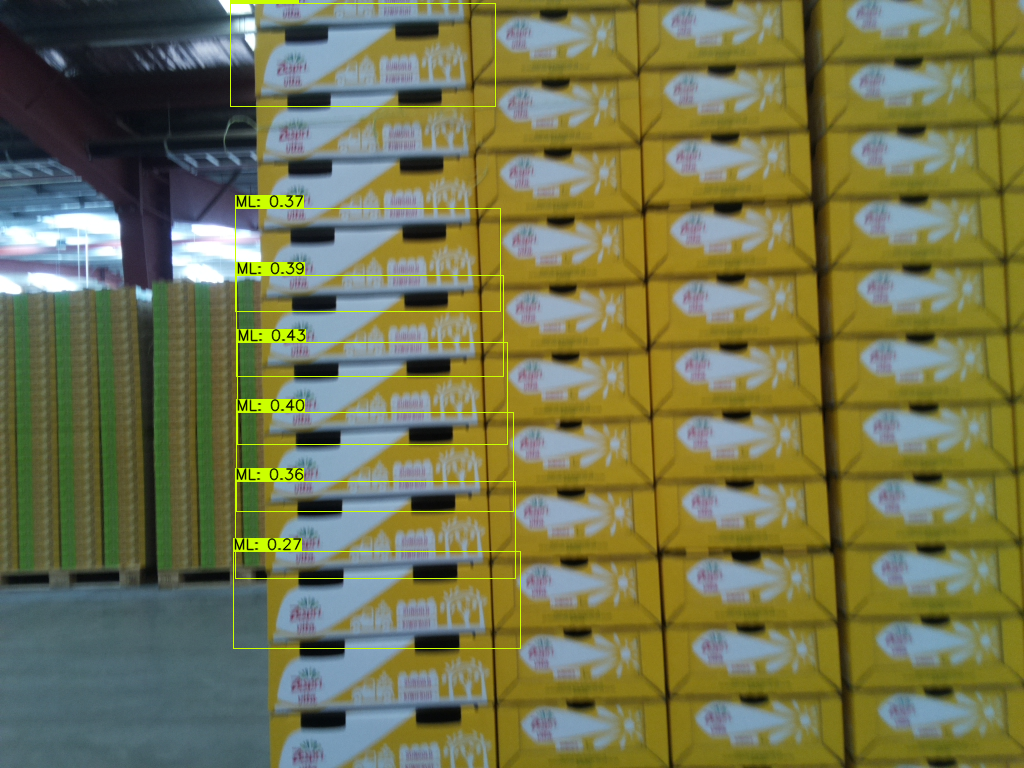

In [ ]:
%cd /content/kiwiboxset/tensorflow-yolov4-tflite/
!ls
from IPython.display import Image
Image('/content/kiwiboxset/tensorflow-yolov4-tflite/result.png')

# Eval Model

In [ ]:
# evaluate yolov4 model
%cd /content/kiwiboxset/tensorflow-yolov4-tflite/
!python evaluate.py --weights /content/kiwiboxset/tensorflow-yolov4-tflite/checkpoints/yolov4-tiny-1024768v5/  --tiny True  --size 1024x768 --model yolov4
#%cd mAP/extra
#python remove_space.py
#%cd ..
#python main.py --output results_yolov4_tf

In [ ]:
%cd /content/kiwiboxset/tensorflow-yolov4-tflite/mAP
#%cd mAP/extra
#!python remove_space.py
#%cd ..
!python main.py --output results_yolov4_tf